# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [1]:
import os, torch, copy, cv2, sys, random
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
import plotly
from torchvision import transforms
import random

# 시드 고정
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  
seed_everything()

## Set Arguments & hyperparameters

In [2]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= './data'
NUM_CLS = 2

EPOCHS = 581
BATCH_SIZE = 32
MOMENTUM = 0.5
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 128

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape, augmentation=False):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        self.augmentation = augmentation
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
            
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
            
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        if self.augmentation :
            self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.5),
                                                 # transforms.RandomInvert(p=0.5),
                                                 transforms.RandomAdjustSharpness(sharpness_factor=1),
                                                 # transforms.RandomPosterize(bits=2),
                                                 # transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0.2),
                                                 # transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
                                                 transforms.RandomVerticalFlip(p = 0.5),
                                                 # transforms.RandomRotation((-180,180)),
                                                 transforms.Resize(self.input_shape),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        else :
            self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']


In [5]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augmentation=True)
valid_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_len = len(train_dataset)
valid_len = len(valid_dataset)
print('Train set samples:',train_len,  'Val set samples:', valid_len)

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


## Utils
### EarlyStopper

In [6]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter > self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

In [7]:
class AccuracyEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): accuracy가 늘어나지 않아도 학습할 epoch 수
        patience_counter (int): accuracy 가 늘어나지 않을 때 마다 1씩 증가, 증가 시 0으로 리셋
        max_accuracy (float): 최대 accuracy
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.max_accuracy = -np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, accuracy: float)-> None:
        """Early stopping 여부 판단"""  

        if self.max_accuracy <= -np.Inf:
            self.max_accuracy = accuracy
            return None

        elif accuracy <= self.max_accuracy:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter > self.patience:
                self.stop = True
                
        elif accuracy > self.max_accuracy:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation accuracy Increased {self.max_accuracy} -> {accuracy}"
            self.max_accuracy = accuracy
        
        print(msg)

### Trainer

In [8]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for idx, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / idx
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for idx, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / idx
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [9]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Optuna

https://ichi.pro/ko/optunalo-pytorch-haipeopalamiteo-jojeong-4883072668892

seed 고정했지만 돌릴때마다 결과 다름..

In [10]:
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn
early_stopper = AccuracyEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

### Model to optimize

In [11]:
import torch.nn.functional as F
import torchvision.models as models

# vgg16 = models.vgg16()
# print(vgg16)

class custom_CNN_optuna(nn.Module):
    def __init__(self, num_classes, trial):
        super(custom_CNN_optuna, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        droprate1 = trial.suggest_float("droprate1", 0, 0.2)
        self.dropout1 = nn.Dropout(p=droprate1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        droprate2 = trial.suggest_float("droprate2", 0, 0.2)
        self.dropout2 = nn.Dropout(p=droprate2)
        fc1_output = trial.suggest_int("fc1_output", 200, 1000)
        self.fc1 = nn.Linear(in_features=25*29*29, out_features=fc1_output)
        droprate3 = trial.suggest_float("droprate3", 0, 0.2)
        self.dropout3 = nn.Dropout(p=droprate3)
        self.fc2 = nn.Linear(in_features=fc1_output, out_features=num_classes)
        droprate4 = trial.suggest_float("droprate4", 0.0, 0.5)
        self.dropout4 = nn.Dropout(p=droprate4)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        x = self.dropout2(x)
        
        x = torch.flatten(x,1)
        x = self.dropout3(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x =self.fc2(x)
        x = torch.sigmoid(x)
        
        output = self.softmax(x)
        
        return output

In [12]:
# class custom_CNN_optuna(nn.Module):
#     def __init__(self, num_classes, trial):
#         super(custom_CNN_optuna, self).__init__()
#         self.resnet18 = models.resnet18()
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         droprate1 = trial.suggest_float("droprate1", 0, 0.2)
#         self.dropout1 = nn.Dropout(p=droprate1)
#         fc1_output = trial.suggest_int("fc1_output", 100, 1000)
#         self.fc1 = nn.Linear(in_features=1000, out_features=fc1_output)
#         droprate2 = trial.suggest_float("droprate2", 0, 0.2)
#         self.dropout2 = nn.Dropout(p=droprate2)
#         self.fc2 = nn.Linear(in_features=fc1_output, out_features=num_classes)
#         self.softmax = nn.Softmax(dim=1)
#         droprate3 = trial.suggest_float("droprate3", 0, 0.5)
#         self.dropout3 = nn.Dropout(p=droprate3)
        
#     def forward(self, x):
#         x = self.resnet18(x)
#         x = F.relu(x)
#         x = self.dropout1(x)       
#         x = torch.flatten(x,1)
#         x = self.dropout2(x)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout3(x)
#         x =self.fc2(x)
#         x = torch.sigmoid(x)

#         output = self.softmax(x)
        
#         return output

In [13]:
def objective(trial: optuna.Trial):

    # Generate the model.
    model = custom_CNN_optuna(NUM_CLS, trial)
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["RAdam","AdamW","NAdam"])
    lr = trial.suggest_float("lr", 1e-7, 1e-1, log=True)
    # momentum = trial.suggest_float("momentum",0.0,3.0)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.01, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
    loss_fn = nn.BCELoss()
    metric_fn = get_metric_fn

    for epoch in range(EPOCHS):
        model.train()
        train_total_loss = 0
        train_target_lst = []
        train_pred_lst = []
        train_prob_lst = []
        for idx, (img, label) in enumerate(train_dataloader):
            img = img.to(DEVICE)
            label = label.to(DEVICE).float()
            pred = model(img)
            loss = loss_fn(pred[:,1], label)
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            scheduler.step()
            train_total_loss += loss.item()
            train_prob_lst.extend(pred[:, 1].cpu().tolist())
            train_target_lst.extend(label.cpu().tolist())
            train_pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        train_mean_loss = train_total_loss / idx
        train_score, f1 = metric_fn(y_pred=train_pred_lst, y_answer=train_target_lst)
        msg = f'Epoch {epoch}, Train loss: {train_mean_loss}, Acc: {train_score}, F1-Macro: {f1}'
        print(msg)

        # Validation of the model.
        model.eval()
        val_total_loss = 0
        val_target_lst = []
        val_pred_lst = []
        val_prob_lst = []
        with torch.no_grad():
            for idx, (img, label) in enumerate(valid_dataloader):
                img = img.to(DEVICE)
                label = label.to(DEVICE).float()
                pred = model(img)
                # Get the index of the max log-probability.
                loss = loss_fn(pred[:,1], label)
                val_total_loss += loss.item()
                val_prob_lst.extend(pred[:, 1].cpu().tolist())
                val_target_lst.extend(label.cpu().tolist())
                val_pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        val_mean_loss = val_total_loss / idx
        validation_score, f1 = metric_fn(y_pred=val_pred_lst, y_answer=val_target_lst)
        msg = f'Epoch {epoch}, Val loss: {val_mean_loss}, Acc: {validation_score}, F1-Macro: {f1}'
        print(msg)
        
        early_stopper.check_early_stopping(accuracy=validation_score)
        if early_stopper.stop:
            print('Early stopped')
            break
        # Handle pruning based on the intermediate value.
        if trial.should_prune(): #더이상 의미가 없다고 생각하면 early stop
            raise optuna.exceptions.TrialPruned()

    return train_score


In [14]:
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {"project": "cnn"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="accuracy")

study = optuna.create_study(direction="maximize", 
                            sampler=optuna.samplers.CmaEsSampler(), # if not set, TPESampler (single-objective optimization) / NSGAIISampler (multi-objective optimization) as default
                            pruner=optuna.pruners.SuccessiveHalvingPruner()
                            )
study.optimize(objective, n_trials=50, timeout=600, callbacks=[wandbc])

/tmp/ipykernel_48116/825570787.py:5: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="accuracy")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: melebele (use `wandb login --relogin` to force relogin)


[I 2022-02-15 03:10:23,159] A new study created in memory with name: no-name-54a10995-6711-4b6b-8343-2ffa9311e066


Epoch 0, Train loss: 0.7324312329292297, Acc: 0.4750430292598967, F1-Macro: 0.4722853390590149
Epoch 0, Val loss: 1.0432699024677277, Acc: 0.5692307692307692, F1-Macro: 0.5608108108108109
Epoch 1, Train loss: 0.7256125542852614, Acc: 0.5456110154905336, F1-Macro: 0.3877766069546891
Epoch 1, Val loss: 1.0052501857280731, Acc: 0.5384615384615384, F1-Macro: 0.45833333333333337
Early stopping counter 1/10
Epoch 2, Train loss: 0.707544356584549, Acc: 0.621342512908778, F1-Macro: 0.6208471760797343
Epoch 2, Val loss: 0.9762477874755859, Acc: 0.7230769230769231, F1-Macro: 0.7230113636363635
Validation accuracy Increased 0.5692307692307692 -> 0.7230769230769231
Epoch 3, Train loss: 0.6910541819201576, Acc: 0.6592082616179001, F1-Macro: 0.658235294117647
Epoch 3, Val loss: 0.8852285146713257, Acc: 0.6923076923076923, F1-Macro: 0.6886973180076628
Early stopping counter 1/10
Epoch 4, Train loss: 0.6647379431459639, Acc: 0.6540447504302926, F1-Macro: 0.6538971065476843
Epoch 4, Val loss: 0.7794169

[I 2022-02-15 03:26:54,641] Trial 0 finished with value: 0.7452667814113597 and parameters: {'droprate1': 0.1172806614955634, 'droprate2': 0.09364913122828147, 'fc1_output': 236, 'droprate3': 0.1948537725194478, 'droprate4': 0.016476388770697237, 'optimizer': 'AdamW', 'lr': 0.0008301724069009814}. Best is trial 0 with value: 0.7452667814113597.


Epoch 21, Val loss: 0.8105495125055313, Acc: 0.6461538461538462, F1-Macro: 0.6091503267973856
Early stopping counter 11/10
Early stopped


### Hyperparmeter 분석

In [15]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'droprate1': 0.1172806614955634, 'droprate2': 0.09364913122828147, 'fc1_output': 236, 'droprate3': 0.1948537725194478, 'droprate4': 0.016476388770697237, 'optimizer': 'AdamW', 'lr': 0.0008301724069009814}
Best metric observed: 0.7452667814113597


In [16]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0       0  0.745267 2022-02-15 03:10:23.161320 2022-02-15 03:26:54.640058   

                duration  params_droprate1  params_droprate2  \
0 0 days 00:16:31.478738          0.117281          0.093649   

   params_droprate3  params_droprate4  params_fc1_output  params_lr  \
0          0.194854          0.016476                236    0.00083   

  params_optimizer     state  
0            AdamW  COMPLETE

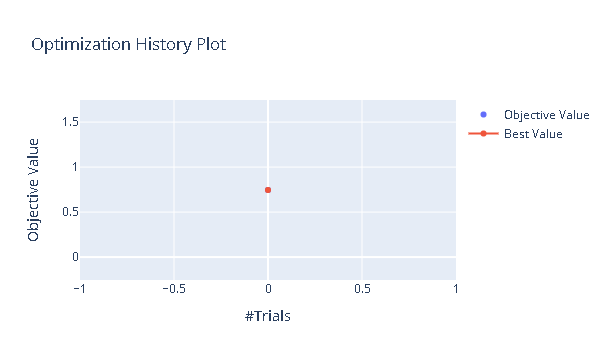

In [17]:
optuna.visualization.plot_optimization_history(study)

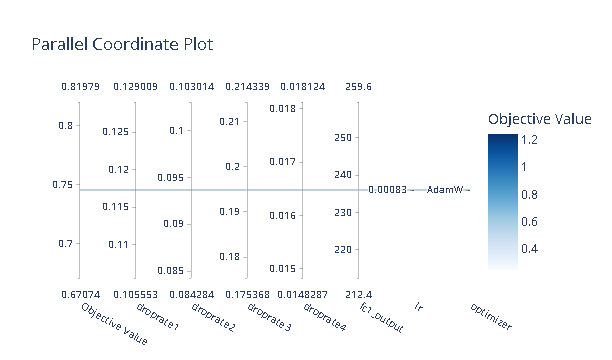

In [18]:
optuna.visualization.plot_parallel_coordinate(study)

In [19]:
# # trials_dataframe() 여러개 쌓여야 실행가능
# optuna.visualization.plot_param_importances(study)

### epoch 단위 학습 진행

In [ ]:
trial = study.best_trial
model = custom_CNN_optuna(NUM_CLS, trial).to(DEVICE)
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)
LEARNING_RATE = study.best_params['lr']
# MOMENTUM = study.best_params['momentum']
optimizer_name = study.best_params['optimizer']
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)
for epoch_index in tqdm(range(EPOCHS)):
    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(valid_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/581 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7320372727182176, Acc: 0.5438898450946644, F1-Macro: 0.46257221145958777


  0% 1/581 [00:44<7:09:36, 44.44s/it]

Epoch 0, Val loss: 1.0384970903396606, Acc: 0.46153846153846156, F1-Macro: 0.45691095726903797
Epoch 1, Train loss: 0.7316961785157522, Acc: 0.5232358003442341, F1-Macro: 0.4364497140876191


  0% 2/581 [01:29<7:09:49, 44.54s/it]

Epoch 1, Val loss: 1.0552872717380524, Acc: 0.4461538461538462, F1-Macro: 0.44285714285714284
Early stopping counter 1/10
Epoch 2, Train loss: 0.7306855585840013, Acc: 0.5215146299483648, F1-Macro: 0.4405721806594625
Epoch 2, Val loss: 1.0369058549404144, Acc: 0.46153846153846156, F1-Macro: 0.46102819237147596
Validation loss decreased 1.0384970903396606 -> 1.0369058549404144


  1% 3/581 [02:13<7:09:45, 44.61s/it]

Epoch 3, Train loss: 0.7317008144325681, Acc: 0.5559380378657487, F1-Macro: 0.4808187863674148
Epoch 3, Val loss: 1.044624000787735, Acc: 0.47692307692307695, F1-Macro: 0.4738095238095238
Early stopping counter 1/10


  1% 4/581 [02:58<7:10:02, 44.72s/it]

Epoch 4, Train loss: 0.7321737077501085, Acc: 0.5146299483648882, F1-Macro: 0.4530139949789007
Epoch 4, Val loss: 1.0365441739559174, Acc: 0.46153846153846156, F1-Macro: 0.4532564287430906
Validation loss decreased 1.0369058549404144 -> 1.0365441739559174


  1% 5/581 [03:44<7:10:46, 44.87s/it]

Epoch 5, Train loss: 0.7285489837328593, Acc: 0.5869191049913941, F1-Macro: 0.5688311688311689
Epoch 5, Val loss: 1.035546898841858, Acc: 0.5076923076923077, F1-Macro: 0.4503171247357294
Validation loss decreased 1.0365441739559174 -> 1.035546898841858


  1% 6/581 [04:29<7:10:52, 44.96s/it]

Epoch 6, Train loss: 0.7264803780449761, Acc: 0.5645438898450946, F1-Macro: 0.5523214911145289
Epoch 6, Val loss: 1.0336009562015533, Acc: 0.5692307692307692, F1-Macro: 0.545
Validation loss decreased 1.035546898841858 -> 1.0336009562015533


  1% 7/581 [05:14<7:11:25, 45.10s/it]

Epoch 7, Train loss: 0.7235799961619906, Acc: 0.6144578313253012, F1-Macro: 0.6075650118203311
Epoch 7, Val loss: 1.0148289203643799, Acc: 0.6615384615384615, F1-Macro: 0.6549227799227799
Validation loss decreased 1.0336009562015533 -> 1.0148289203643799


  1% 8/581 [05:59<7:08:41, 44.89s/it]

Epoch 8, Train loss: 0.7246620059013367, Acc: 0.6024096385542169, F1-Macro: 0.567988025686833
Epoch 8, Val loss: 0.9901024997234344, Acc: 0.7538461538461538, F1-Macro: 0.7533206831119545
Validation loss decreased 1.0148289203643799 -> 0.9901024997234344


  2% 9/581 [06:44<7:08:32, 44.95s/it]

Epoch 9, Train loss: 0.7150805989901224, Acc: 0.6230636833046471, F1-Macro: 0.6187218511493271
Epoch 9, Val loss: 1.0509348213672638, Acc: 0.5692307692307692, F1-Macro: 0.5190274841437632
Early stopping counter 1/10


  2% 10/581 [07:29<7:09:35, 45.14s/it]

Epoch 10, Train loss: 0.7142393224769168, Acc: 0.6058519793459552, F1-Macro: 0.5894879745761405
Epoch 10, Val loss: 1.03164741396904, Acc: 0.6307692307692307, F1-Macro: 0.5962732919254659
Early stopping counter 2/10


  2% 11/581 [08:14<7:08:31, 45.11s/it]

Epoch 11, Train loss: 0.7047858834266663, Acc: 0.657487091222031, F1-Macro: 0.6561670111370497
Epoch 11, Val loss: 0.9796474575996399, Acc: 0.6615384615384615, F1-Macro: 0.6549227799227799
Validation loss decreased 0.9901024997234344 -> 0.9796474575996399


  2% 12/581 [08:59<7:06:05, 44.93s/it]

Epoch 12, Train loss: 0.6977437337239584, Acc: 0.6643717728055077, F1-Macro: 0.6641170454040112
Epoch 12, Val loss: 0.9534369111061096, Acc: 0.6307692307692307, F1-Macro: 0.61
Validation loss decreased 0.9796474575996399 -> 0.9534369111061096


  2% 13/581 [09:44<7:05:05, 44.90s/it]

Epoch 13, Train loss: 0.6942545043097602, Acc: 0.657487091222031, F1-Macro: 0.6571580223996774
Epoch 13, Val loss: 0.9806961715221405, Acc: 0.7384615384615385, F1-Macro: 0.7374673319078167
Early stopping counter 1/10


  2% 14/581 [10:29<7:04:03, 44.87s/it]

Epoch 14, Train loss: 0.681095861726337, Acc: 0.6471600688468159, F1-Macro: 0.6372565441837093
Epoch 14, Val loss: 0.9359944462776184, Acc: 0.6307692307692307, F1-Macro: 0.6036585365853657
Validation loss decreased 0.9534369111061096 -> 0.9359944462776184


  3% 15/581 [11:14<7:04:00, 44.95s/it]

Epoch 15, Train loss: 0.6811027593082852, Acc: 0.6660929432013769, F1-Macro: 0.6659732100521574
Epoch 15, Val loss: 0.8806920349597931, Acc: 0.7384615384615385, F1-Macro: 0.7374673319078167
Validation loss decreased 0.9359944462776184 -> 0.8806920349597931


  3% 16/581 [11:58<7:02:28, 44.86s/it]

Epoch 16, Train loss: 0.662148137887319, Acc: 0.6919104991394148, F1-Macro: 0.6905869087252354
Epoch 16, Val loss: 0.9202566742897034, Acc: 0.6461538461538462, F1-Macro: 0.6233308138070043
Early stopping counter 1/10


  3% 17/581 [12:43<7:00:31, 44.74s/it]

Epoch 17, Train loss: 0.6754763060145907, Acc: 0.6540447504302926, F1-Macro: 0.6537821852625962
Epoch 17, Val loss: 0.9679824113845825, Acc: 0.7230769230769231, F1-Macro: 0.7198275862068966
Early stopping counter 2/10


  3% 18/581 [13:27<6:59:05, 44.66s/it]

Epoch 18, Train loss: 0.6539573338296678, Acc: 0.685025817555938, F1-Macro: 0.6848428260192967
Epoch 18, Val loss: 0.8365450501441956, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449184
Validation loss decreased 0.8806920349597931 -> 0.8365450501441956


  3% 19/581 [14:12<6:58:41, 44.70s/it]

Epoch 19, Train loss: 0.6568656663099924, Acc: 0.6643717728055077, F1-Macro: 0.6641767818238407
Epoch 19, Val loss: 0.8752287030220032, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449184
Early stopping counter 1/10


  3% 20/581 [14:57<6:57:44, 44.68s/it]

Epoch 20, Train loss: 0.6394441293345557, Acc: 0.693631669535284, F1-Macro: 0.6934782093232797
Epoch 20, Val loss: 0.7802738398313522, Acc: 0.7384615384615385, F1-Macro: 0.7374673319078167
Validation loss decreased 0.8365450501441956 -> 0.7802738398313522


  4% 21/581 [15:41<6:55:52, 44.56s/it]

Epoch 21, Train loss: 0.6428139474656847, Acc: 0.6987951807228916, F1-Macro: 0.6986201888162672
Epoch 21, Val loss: 0.80023293197155, Acc: 0.7384615384615385, F1-Macro: 0.7374673319078167
Early stopping counter 1/10


  4% 22/581 [16:26<6:55:50, 44.63s/it]

Epoch 22, Train loss: 0.6286068111658096, Acc: 0.6867469879518072, F1-Macro: 0.6832554517133956
Epoch 22, Val loss: 0.7815666347742081, Acc: 0.7230769230769231, F1-Macro: 0.7198275862068966
Early stopping counter 2/10


  4% 23/581 [17:11<6:56:23, 44.77s/it]

Epoch 23, Train loss: 0.6246990429030524, Acc: 0.7142857142857143, F1-Macro: 0.7131222634684942
Epoch 23, Val loss: 0.8142404705286026, Acc: 0.7076923076923077, F1-Macro: 0.7031963470319635
Early stopping counter 3/10


  4% 24/581 [17:57<6:58:47, 45.11s/it]

Epoch 24, Train loss: 0.6157074802451663, Acc: 0.7280550774526678, F1-Macro: 0.7275506327611179
Epoch 24, Val loss: 0.8115606606006622, Acc: 0.6923076923076923, F1-Macro: 0.6862934362934363
Early stopping counter 4/10


  4% 25/581 [18:43<7:00:14, 45.35s/it]

Epoch 25, Train loss: 0.6049074017339282, Acc: 0.7469879518072289, F1-Macro: 0.746398952422523
Epoch 25, Val loss: 0.8715178966522217, Acc: 0.7384615384615385, F1-Macro: 0.7344388368180725
Early stopping counter 5/10


  4% 26/581 [19:28<6:59:54, 45.39s/it]

Epoch 26, Train loss: 0.624769518772761, Acc: 0.7108433734939759, F1-Macro: 0.7104651162790697
Epoch 26, Val loss: 0.744512066245079, Acc: 0.7384615384615385, F1-Macro: 0.7292330311198234
Validation loss decreased 0.7802738398313522 -> 0.744512066245079


  5% 27/581 [20:13<6:57:58, 45.27s/it]

Epoch 27, Train loss: 0.6277457906140221, Acc: 0.6970740103270223, F1-Macro: 0.6943348398976492
Epoch 27, Val loss: 0.7092920541763306, Acc: 0.8153846153846154, F1-Macro: 0.8142857142857143
Validation loss decreased 0.744512066245079 -> 0.7092920541763306


  5% 28/581 [20:57<6:53:45, 44.89s/it]

Epoch 28, Train loss: 0.5949620852867762, Acc: 0.7452667814113597, F1-Macro: 0.7438637880087695
Epoch 28, Val loss: 0.8580098748207092, Acc: 0.7230769230769231, F1-Macro: 0.7149122807017544
Early stopping counter 1/10


  5% 29/581 [21:42<6:53:33, 44.95s/it]

Epoch 29, Train loss: 0.6119314663940005, Acc: 0.7401032702237521, F1-Macro: 0.7389867218855339
Epoch 29, Val loss: 0.7384432852268219, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449184
Early stopping counter 2/10


  5% 30/581 [22:27<6:52:52, 44.96s/it]

Epoch 30, Train loss: 0.5704614867766699, Acc: 0.7693631669535284, F1-Macro: 0.7677109440267336
Epoch 30, Val loss: 0.7280782759189606, Acc: 0.7384615384615385, F1-Macro: 0.7344388368180725
Early stopping counter 3/10


  5% 31/581 [23:12<6:52:34, 45.01s/it]

Epoch 31, Train loss: 0.5906162444088194, Acc: 0.7469879518072289, F1-Macro: 0.745782992668792
Epoch 31, Val loss: 0.8498072922229767, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Early stopping counter 4/10


  6% 32/581 [23:57<6:51:52, 45.01s/it]

Epoch 32, Train loss: 0.5684788276751837, Acc: 0.76592082616179, F1-Macro: 0.7638041944663654
Epoch 32, Val loss: 0.7101868391036987, Acc: 0.7384615384615385, F1-Macro: 0.7292330311198234
Early stopping counter 5/10


  6% 33/581 [24:42<6:49:57, 44.89s/it]

Epoch 33, Train loss: 0.575831178161833, Acc: 0.7676419965576592, F1-Macro: 0.7659082972951194
Epoch 33, Val loss: 0.761060819029808, Acc: 0.7076923076923077, F1-Macro: 0.677124183006536
Early stopping counter 6/10


  6% 34/581 [25:26<6:47:56, 44.75s/it]

Epoch 34, Train loss: 0.5921994116571214, Acc: 0.7555938037865749, F1-Macro: 0.7555930797487854
Epoch 34, Val loss: 0.7942211925983429, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 7/10


  6% 35/581 [26:12<6:48:32, 44.89s/it]

Epoch 35, Train loss: 0.5865575969219208, Acc: 0.7555938037865749, F1-Macro: 0.749987878494024
Epoch 35, Val loss: 1.1573788076639175, Acc: 0.7538461538461538, F1-Macro: 0.74
Early stopping counter 8/10


  6% 36/581 [26:57<6:49:15, 45.06s/it]

Epoch 36, Train loss: 0.5935934434334437, Acc: 0.7366609294320138, F1-Macro: 0.7365079365079366
Epoch 36, Val loss: 0.8073327839374542, Acc: 0.8153846153846154, F1-Macro: 0.8117760617760618
Early stopping counter 9/10


  6% 37/581 [27:41<6:46:43, 44.86s/it]

Epoch 37, Train loss: 0.5618868701987796, Acc: 0.7676419965576592, F1-Macro: 0.7654631083202512
Epoch 37, Val loss: 0.7494610846042633, Acc: 0.7692307692307693, F1-Macro: 0.7580044676098288
Early stopping counter 10/10


  7% 38/581 [28:26<6:45:34, 44.82s/it]

Epoch 38, Train loss: 0.5687111086315579, Acc: 0.7865748709122203, F1-Macro: 0.785608856088561
Epoch 38, Val loss: 0.6833299994468689, Acc: 0.8153846153846154, F1-Macro: 0.8149905123339659
Validation loss decreased 0.7092920541763306 -> 0.6833299994468689


  7% 39/581 [29:11<6:44:46, 44.81s/it]

Epoch 39, Train loss: 0.5538457300927904, Acc: 0.7848537005163512, F1-Macro: 0.783116375049648
Epoch 39, Val loss: 0.6464224308729172, Acc: 0.8153846153846154, F1-Macro: 0.8153409090909092
Validation loss decreased 0.6833299994468689 -> 0.6464224308729172


  7% 40/581 [29:55<6:43:10, 44.71s/it]

Epoch 40, Train loss: 0.5402284810940424, Acc: 0.8037865748709122, F1-Macro: 0.8022629567709577
Epoch 40, Val loss: 0.668901726603508, Acc: 0.8461538461538461, F1-Macro: 0.8443486590038314
Early stopping counter 1/10


  7% 41/581 [30:40<6:41:39, 44.63s/it]

Epoch 41, Train loss: 0.5602682017617755, Acc: 0.7728055077452668, F1-Macro: 0.7717771693845972
Epoch 41, Val loss: 0.6738826781511307, Acc: 0.8461538461538461, F1-Macro: 0.8458254269449716
Early stopping counter 2/10


  7% 42/581 [31:25<6:43:32, 44.92s/it]

Epoch 42, Train loss: 0.5510838710599475, Acc: 0.7814113597246127, F1-Macro: 0.7812013509786885
Epoch 42, Val loss: 0.7741590291261673, Acc: 0.8, F1-Macro: 0.7982812126999284
Early stopping counter 3/10


  7% 43/581 [32:11<6:43:46, 45.03s/it]

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

## Inference
### 모델 로드

### Load dataset

In [ ]:
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 추론 진행

In [ ]:
TRAINED_MODEL_PATH = 'best.pt'
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)